# Assignment 6: Floods

*Due date: March 16*

*4 pts + 2 final project points*

In this assignment, we will look at flow data from the Feather River just downstream of the Oroville Dam, in order to figure out the statistical frequency of the recent high-flow event.

Questions are interspersed among the "tutorial"-type material below. Please **submit your assignment as an html export**, and for written responses, please type them in a cell that is of type `Markdown.`

In [4]:
# Import numerical tools
import numpy as np

#Import pandas for reading in and managing data
import pandas as pd

# Import pyplot for plotting
import matplotlib.pyplot as plt

#Import seaborn (useful for plotting)
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

%config InlineBackend.figure_formats = {'svg',}
#%config InlineBackend.figure_formats = {'png', 'retina'}

## Importing data
Unfortunately, the USGS does not have any data from this year available from the Feather River or its tributaries. (For this river, it only makes data available after staff hydrologists have had a chance to review it.) I was, however, able to find recent data available from a station maintained by the CA Department of Water Resources (DWR) on [this website](https://cdec.water.ca.gov/queryCSV.html). The station is the Feather River at Gridley, which is just downstream of Oroville. However, the period of record only goes back to 1984 (in contrast to some of the USGS stations with periods of record back to the early 1900s.) The [DWR data](https://drive.google.com/file/d/0BzoZUD3hISA4U0FPWHdna3pCZFU/view?usp=sharing) is downloadable as a CSV, in which the columns represent data collected on the hour over the 24 hours of the day, and the rows represent days in the period of record. Let's import it and begin to work with it. First, make sure the data file is saved to your computer.

In [6]:
# Use pd.read_csv() to read in the data and store in a DataFrame
fname = '/Users/lglarsen/Desktop/Laurel Google Drive/Terrestrial hydrology Spr2017/Assignments/Assignment 6/FeatherRiveratGridley.csv'
df = pd.read_csv(fname)
df.head()

,'station','sensor',year-month-day,0,100,200,300,400,500,600,...,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
0,GRL,20.0,19840101.0,-9998.0,37400.0,37100.0,36900.0,36800.0,36500.0,36100.0,...,31700.0,31600.0,31400.0,31300.0,31300.0,31100.0,30900.0,30900.0,30800.0,30700.0
1,GRL,20.0,19840102.0,30600.0,30600.0,-9998.0,-9998.0,-9998.0,30200.0,29900.0,...,25000.0,24000.0,23100.0,22200.0,21200.0,20600.0,20100.0,19800.0,19700.0,19500.0
2,GRL,20.0,19840103.0,19400.0,19300.0,19200.0,19100.0,19000.0,18900.0,18900.0,...,18900.0,18900.0,18900.0,18800.0,18800.0,18800.0,18800.0,18700.0,18600.0,18600.0
3,GRL,20.0,19840104.0,18600.0,18600.0,18600.0,18600.0,18600.0,18500.0,18500.0,...,18400.0,18400.0,18400.0,18400.0,18400.0,18400.0,18300.0,18300.0,18300.0,18300.0
4,GRL,20.0,19840105.0,18200.0,18200.0,18200.0,18200.0,18200.0,18100.0,18100.0,...,18100.0,18100.0,18100.0,18100.0,18100.0,18100.0,18100.0,18100.0,18100.0,-9998.0


Note that discharge is in units of cfs, or cubic feet per second. You'll notice that missing data has been assigned the value -9998. Below we will correct the blanks to nan and then convert the discharge data to an array using the `values` function in the pandas package.

In [7]:
hoursbyday = df[['0', '100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '1100', '1200', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300']].values

Now we will embark on a sophisticated approach for removing blank values.  We'll interpolate them using pandas' interpolate function, but only when half the day's data values are valid. Finally, we will add all of the hourly values to create a daily value. If there were more than 12 blanks in a day, the daily value will end up as an NaN.

So that you can see how this loop works, I suggest changing the first line to `for i in range(2):` and uncommenting the two `print` statements at the end of the code. The two questions below require you to do this.

1. **Concept check**: In the first row of the data table, how many NaNs do you end up with after the blank interpolation procedure? Why? [1/3 pt]

2. **Concept check**: What is the big difference in the daily sum between the first and second rows of the data table? Why? [1/3 pt]

In [8]:
#First, initialize the daily discharge array
dailyQ = np.zeros(np.size(hoursbyday,0)) #This makes the daily discharge array have the same length
#as the number of rows in hoursbyday.

for i in range(np.size(hoursbyday,0)): #This means to iterate over the number of rows in hoursbyday
    dayvals = hoursbyday[i,:] #Grab the row of hourly values for each day you are iterating over.
    
    #Now we're going to pad this array with the last 12 values from the day before and the first 12 values from the day after.
    #This is in case we need to get rid of blanks at the beginning or end of the day.
    
    if i>0:
        dayvals = np.append(hoursbyday[i-1,12:23], dayvals)
    else: #If this is the first row, pad the values with blanks
        dayvals = np.append(np.ones(12)*-9998, dayvals)
    if i==np.size(hoursbyday,0)-1: #if this is the last line in the data file
        dayvals = np.append(dayvals, np.ones(12)*-9998)
    else: #If this is not the last row
        dayvals = np.append(dayvals, hoursbyday[i+1,0:11])

    #Now we interpolate the missing values.
    dayvals[dayvals<0]=np.nan #Convert blanks to NaN values
    pandas_dayvals = pd.Series(dayvals)#I'm converting back to a pandas object because pandas has a useful interpolate function

    #Linearly interpolate across the blanks, but only if there are no more than 12 blanks in a row
    pandas_dayvals = pandas_dayvals.interpolate(limit=12)
    
    #Last, we'll convert back to a numpy array and just grab the original set of data for that day.
    dayvals = pandas_dayvals[12:35].values
    print(dayvals)
    
    #Finally, add all of the values to acquire a daily discharge.
    dailyQ[i] = np.sum(dayvals)
    print(dailyQ[i])

[    nan  37400.  37100.  36900.  36800.  36500.  36100.  35400.  34300.
  33700.  32900.  32500.  32100.  31500.  31700.  31600.  31400.  31300.
  31300.  31100.  30900.  30900.  30800.]
nan
[ 30600.   30500.   30400.   30300.   30200.   29900.   29287.5  28675.
  28062.5  27450.   26837.5  26225.   25612.5  25000.   24000.   23100.
  22200.   21200.   20600.   20100.   19800.   19700.   19500. ]
589250.0
[ 19300.  19200.  19100.  19000.  18900.  18900.  18900.  18800.  18800.
  18700.  18700.  18800.  18900.  18900.  18900.  18900.  18800.  18800.
  18800.  18800.  18700.  18600.  18600.]
433800.0
[ 18600.  18600.  18600.  18600.  18500.  18500.  18400.  18300.  18300.
  18300.  18300.  18300.  18300.  18400.  18400.  18400.  18400.  18400.
  18400.  18300.  18300.  18300.  18300.]
423200.0
[ 18200.  18200.  18200.  18200.  18100.  18100.  18100.  18100.  18100.
  18100.  18100.  18100.  18100.  18100.  18100.  18100.  18100.  18100.
  18100.  18100.  18100.  18100.  18100.]
416700.0

In [ ]:
np.size(hoursbyday,0)

11905

Now, let's visualize the whole period of record. 

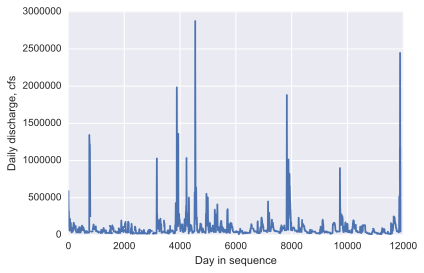

In [12]:
plt.plot(dailyQ)
plt.xlabel('Day in sequence')
plt.ylabel('Daily discharge, cfs')

So you can see that the recent high flow coming out of the Oroville Dam, while pretty darn high, was *not* the highest on record. Let's now look at the data another way...

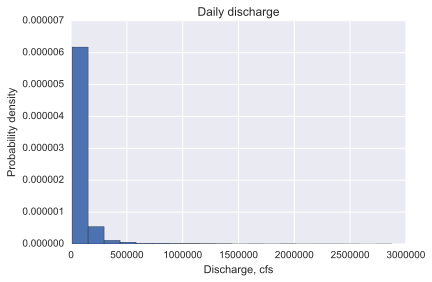

In [13]:
plt.hist(dailyQ[~np.isnan(dailyQ)],20, normed=True) #creates a 20-bin, normalized histogram.
plt.title('Daily discharge')
plt.xlabel('Discharge, cfs')
plt.ylabel('Probability density')

Very skewed! Notice that above, we needed to tell the histogram function only to look at those values of dailyQ that were *not* NaNs, otherwise we get an error.

For extreme flows, we usually want to know the average amount of time that elapses between flows of particular magnitudes. Thus, for a flood frequency cacluation, the next step is to determine the peak daily flow for the year. This is very similar to calculations we made in the precipitation tutorial, which you can find [here](https://github.com/LaurelOak/hydro-teaching-resources/blob/master/PrecipFrequencyAnalyses.ipynb). 

One difference is that the dataset we downloaded is missing some days altogether. Rather than going back and finding the missing days (an onorous task), we are just going to use a `for` loop to calculate the peak value in each year. 

First we need to separate the year from the single date column in the input data file. We can do this in pandas using "date-time" functions, as shown below.

In [14]:
df['year'] = pd.to_datetime(df['year-month-day'], format='%Y%m%d').dt.year #Tell pandas that 
#this column is a date, and then extract just the year and save it to a new column.
year = df['year'].values #Convert this to an array
print(year)

[ 1984.  1984.  1984. ...,  2017.  2017.    nan]


So now let's go through and find the maximimum value of discharge per year.

**3) Concept check**: What does the first line after the for loop below do? [1/3 pt]

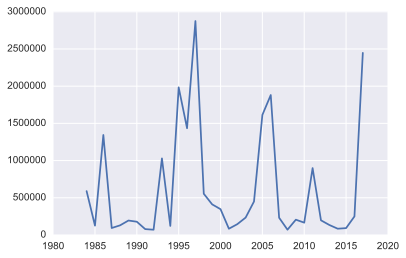

In [15]:
these_years = np.unique(year) #This creates an array of "unique" years in the 'year' array (i.e.,
#with no repeats)
#Initialize the maximum value per year:
maxQ = np.zeros(len(these_years)-1) #One peak discharge per year. Subtracted 1 because the last
#year is a row of NaNs.

for i in range(len(these_years)-1): #Loop over unique years
    these_Q = dailyQ[year==these_years[i]] 
    maxQ[i] = max(these_Q[~np.isnan(these_Q)])
    
plt.plot(these_years[0:len(these_years)-1], maxQ)

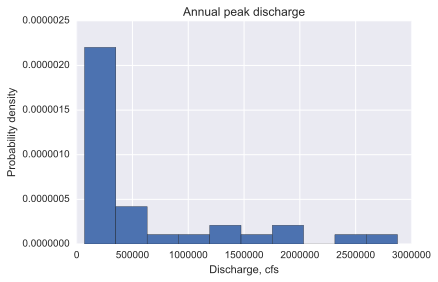

In [16]:
plt.hist(maxQ,10, normed=True) #creates a 10-bin, normalized histogram.
plt.title('Annual peak discharge')
plt.xlabel('Discharge, cfs')
plt.ylabel('Probability density')

**4)** Now, using the Feb 2 class Notebook as a model, develop a Weibull probability plot of the return period vs. annual peakflow value for this period of record. What is the return period of this year's storm according to this method? [1 pt]

In [1]:
#Code for Weibull Probability Analysis goes here

**5)** Now use the Gumbel method to produce a plot of return period vs. peak discharge. What is the return period of this year's storm according to this method? [1 pt]

In [2]:
#Code for Gumbel Probability Analysis goes here

**6)** Provide a critical analysis (1-2 paragraphs) of these two approaches for calculating the return period of this storm, or the so-called 100-year storm for the Feather River. Think about the procedure used for selecting peak flows, as well as that used for calculating their frequencies. If you were a water resource manager, how would you go about generating a reliable estimate of the 1% annual-exceedence-threshold flow? [1 pt]

**7)** Last, go back to the habitatManip.py file that you worked with in the Evapotranspiration assignment. Provide a narrative description of how the seasonal stream habitat model functions. In particular, describe the processes through which streamflow increases and decreases, as well as the processes through which streamside habitat increases and decreases. What happens to streamside habitat as flow goes up? [1 pt]

**8)** Comment on whether you "buy" the way streamside habitat is simulated now. Describe one or more ways through which it might be improved. [1 pt]